# DATA 604 HW 11
## Modeling and Simulation in Python
## Jeff Shamp
Chapter 12

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code

Here's the code from the previous notebook that we'll need.

In [2]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [3]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [4]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

### Metrics

Given the results, we can compute metrics that quantify whatever we are interested in, like the total number of sick students, for example.

In [5]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

Here's an example.|

In [6]:
beta = 0.333
gamma = 0.25
system = make_system(beta, gamma)

results = run_simulation(system, update_func)
print(beta, gamma, calc_total_infected(results))

0.333 0.25 0.46716293183605073


In [7]:
results.I.iloc[-1]

0.0006741943156034474

**Exercise:** Write functions that take a `TimeFrame` object as a parameter and compute the other metrics mentioned in the book:

1.  The fraction of students who are sick at the peak of the outbreak.

2.  The day the outbreak peaks.

3.  The fraction of students who are sick at the end of the semester.

Note: Not all of these functions require the `System` object, but when you write a set of related functons, it is often convenient if they all take the same parameters.

Hint:  If you have a `TimeSeries` called `I`, you can compute the largest value of the series like this:

    I.max()

And the index of the largest value like this:

    I.idxmax()

You can read about these functions in the `Series` [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

In [8]:
# Solution goes here
def peak_infected(results):
    """Fraction of population sick at peak of outbreak.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return results.I.max()
peak_infected(results)

0.043536202687592354

In [9]:
# Solution goes here
def day_outbreakpeak(results):
    """Calculates day outbreak peaks
    
    results: DataFrame with columns S, I, R
    
    returns: day outbreak peaks
    """
    return results.I.idxmax()
day_outbreakpeak(results)

30

In [10]:
# Solution goes here
def end_semester_infected(results):
    """The fraction of students who are sick at the end of the semester.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of students sick at end of semester
    """
    return results.I.iloc[-1]
end_semester_infected(results)

0.0006741943156034474

### What if?

We can use this model to evaluate "what if" scenarios.  For example, this function models the effect of immunization by moving some fraction of the population from S to R before the simulation starts.

In [11]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

Let's start again with the system we used in the previous sections.

In [12]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

,values
init,S 0.988889 I 0.011111 R 0.000000 dtyp...
t0,0
t_end,98
beta,0.333333
gamma,0.25


And run the model without immunization.

In [13]:
results = run_simulation(system, update_func)
calc_total_infected(results)

0.468320811028781

Now with 10% immunization.

In [14]:
system2 = make_system(beta, gamma)
add_immunization(system2, 0.1)
results2 = run_simulation(system2, update_func)
calc_total_infected(results2)

0.30650802853979753

10% immunization leads to a drop in infections of 16 percentage points.

Here's what the time series looks like for S, with and without immunization.

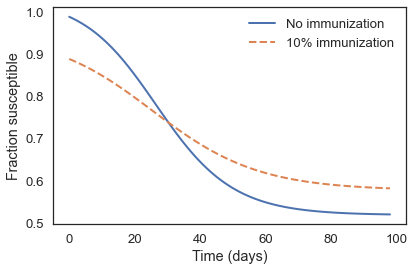

In [15]:
plot(results.S, '-', label='No immunization')
plot(results2.S, '--', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

#savefig('figs/chap12-fig01.pdf')

Now we can sweep through a range of values for the fraction of the population who are immunized.

In [16]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    results = run_simulation(system, update_func)
    print(fraction, calc_total_infected(results))

0.0 0.468320811028781
0.1 0.30650802853979753
0.2 0.16136545700638427
0.30000000000000004 0.0728155898425179
0.4 0.03552021675299155
0.5 0.019688715782459176
0.6000000000000001 0.011622057998337987
0.7000000000000001 0.006838737800619332
0.8 0.003696496253713877
0.9 0.0014815326722661948
1.0 -0.00016121210941239666


This function does the same thing and stores the results in a `Sweep` object.

In [17]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for fraction in immunize_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [18]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

,values
0.00,0.468321
0.05,0.387288
0.10,0.306508
0.15,0.229234
0.20,0.161365
0.25,0.108791
0.30,0.072816
0.35,0.049938
0.40,0.035520
0.45,0.026121


And here's what the results look like.

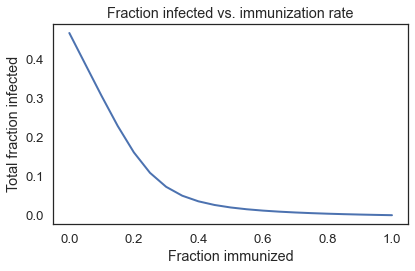

In [19]:
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

#savefig('figs/chap12-fig02.pdf')

If 40% of the population is immunized, less than 4% of the population gets sick.

### Logistic function

To model the effect of a hand-washing campaign, I'll use a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function) (GLF), which is a convenient function for modeling curves that have a generally sigmoid shape.  The parameters of the GLF correspond to various features of the curve in a way that makes it easy to find a function that has the shape you want, based on data or background information about the scenario.

In [20]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

The following array represents the range of possible spending.

In [21]:
spending = linspace(0, 1200, 21)

array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
        540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
       1080., 1140., 1200.])

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20%.

`B` is chosen by trial and error to yield a curve that seems feasible.

In [22]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

Here's what it looks like.

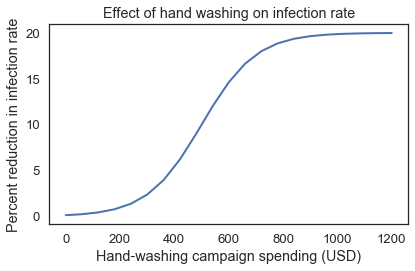

In [23]:
percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

**Exercise:** Modify the parameters `M`, `K`, and `B`, and see what effect they have on the shape of the curve.  Read about the [generalized logistic function on Wikipedia](https://en.wikipedia.org/wiki/Generalised_logistic_function).  Modify the other parameters and see what effect they have.

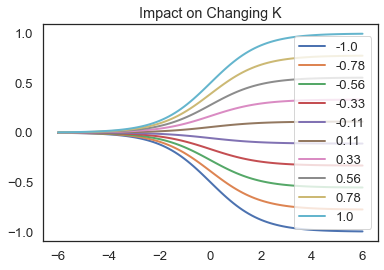

In [24]:
#Modify K--controls the assymptotic bounds for x-> infinity. converges to y=0 as x-> neg infinity 
x=linspace(-6,6,100)
for i in linspace(-1,1,10):
    plot(x,logistic(x,K=i),label=round(i,2))
    plt.title('Impact on Changing K')
    plt.legend()

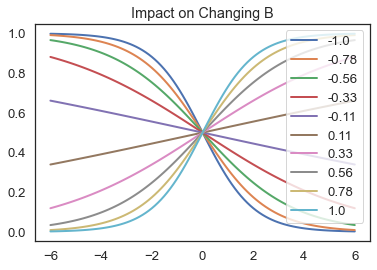

In [25]:
#Modify K--controls the assymptotic bounds--if K is >0 y approaches 0 as x-> neg infinity; y=1 as x-> infinity. if K <0 it's reversed
x=linspace(-6,6,100)
for i in linspace(-1,1,10):
    plot(x,logistic(x,B=i),label=round(i,2))
    plt.title('Impact on Changing B')
    plt.legend()

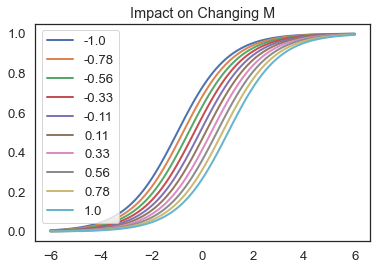

In [26]:
#Modify M--y intercept at x=0; assymptotically approaches y=0 as x->neg infinity and y=1 x-> infinity 
x=linspace(-6,6,100)
for i in linspace(-1,1,10):
    plot(x,logistic(x,M=i),label=round(i,2))
    plt.title('Impact on Changing M')
    plt.legend()

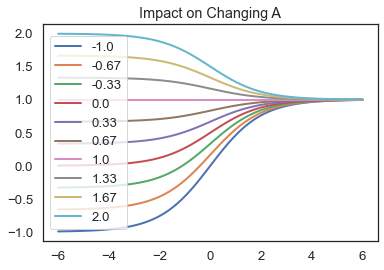

In [27]:
#Modify A--Y limit of x-> -infinity and y=1 for x-> infinity 
x=linspace(-6,6,100)
for i in linspace(-1,2,10):
    plot(x,logistic(x,A=i),label=round(i,2))
    plt.title('Impact on Changing A')
    plt.legend()

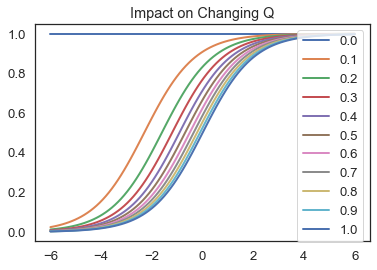

In [28]:
#Modify Q--similar to M and changes the x=0 y intercept. When q=0, equation converges to y=1
x=linspace(-6,6,100)
for i in linspace(0,1,11):
    plot(x,logistic(x,Q=i),label=round(i,2))
    plt.title('Impact on Changing Q')
    plt.legend()

<ipython-input-20-3b865d4f12e7>:16: RuntimeWarning: divide by zero encountered in double_scalars
  return A + (K-A) / denom ** (1/nu)


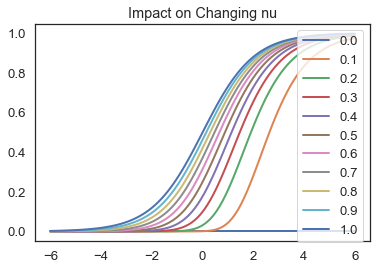

In [29]:
#Modify nu looks like it similar to Q--but nu=1 makes a curve of y=0 
x=linspace(-6,6,100)
for i in linspace(0,1,11):
    plot(x,logistic(x,nu=i),label=round(i,2))
    plt.title('Impact on Changing nu')
    plt.legend()

### Hand washing

Now we can model the effect of a hand-washing campaign by modifying `beta`

In [30]:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

Let's start with the same values of `beta` and `gamma` we've been using.

In [31]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

(0.3333333333333333, 0.25)

Now we can sweep different levels of campaign spending.

In [32]:
spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    system = make_system(beta, gamma)
    add_hand_washing(system, spending)
    results = run_simulation(system, update_func)
    print(spending, system.beta, calc_total_infected(results))

0.0 0.3328871432717143 0.4667702312363652
100.0 0.3321342526691939 0.46414165040064037
200.0 0.33017160845482885 0.4572170063132055
300.0 0.32538647186519215 0.4398872029120663
400.0 0.3154039052420003 0.40163064627138245
500.0 0.3 0.3370342594898199
600.0 0.28459609475799963 0.26731703056804546
700.0 0.2746135281348078 0.22184699045990752
800.0 0.26982839154517113 0.20079159841614402
900.0 0.2678657473308061 0.1923921833925878
1000.0 0.26711285672828566 0.18921320781833872
1100.0 0.26683150821044227 0.18803175228016467
1200.0 0.26672740341296003 0.1875955039953746


Here's a function that sweeps a range of spending and stores the results in a `SweepSeries`.

In [33]:
def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [34]:
spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

,values
0.000000,0.466770
63.157895,0.465418
126.315789,0.462905
189.473684,0.458291
252.631579,0.449980
315.789474,0.435540
378.947368,0.411960
442.105263,0.377183
505.263158,0.333171
568.421053,0.287633


And here's what it looks like.

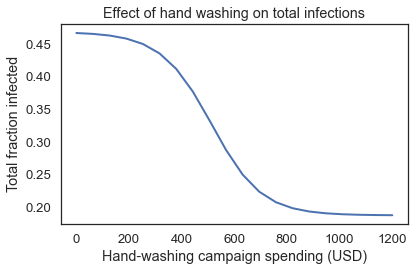

In [35]:
plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections',
         legend=False)


Now let's put it all together to make some public health spending decisions.

### Optimization

Suppose we have \$1200 to spend on any combination of vaccines and a hand-washing campaign.

In [36]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses, endpoint=True)
max_doses

12

We can sweep through a range of doses from, 0 to `max_doses`, model the effects of immunization and the hand-washing campaign, and run simulations.

For each scenario, we compute the fraction of students who get sick.

In [37]:
for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results = run_simulation(system, update_func)
    print(doses, system.init.S, system.beta, calc_total_infected(results))

0 0.9888888888888889 0.26672740341296003 0.1875955039953746
1 0.9777777777777779 0.26683150821044227 0.17458071882622528
2 0.9666666666666667 0.26711285672828566 0.16290983834857686
3 0.9555555555555556 0.2678657473308061 0.15350834947768177
4 0.9444444444444445 0.26982839154517113 0.1485650923152827
5 0.9333333333333333 0.2746135281348078 0.15294595061102179
6 0.9222222222222223 0.28459609475799963 0.1749644150235239
7 0.9111111111111112 0.3 0.21734316168444845
8 0.9 0.3154039052420003 0.2590710444883414
9 0.888888888888889 0.32538647186519215 0.27840288410342784
10 0.8777777777777778 0.33017160845482885 0.2779145346228302
11 0.8666666666666667 0.3321342526691939 0.2673574966927026
12 0.8555555555555556 0.3328871432717143 0.25279694563572175


The following function wraps that loop and stores the results in a `Sweep` object.

In [38]:
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results)

    return sweep

Now we can compute the number of infected students for each possible allocation of the budget.

In [39]:
infected_sweep = sweep_doses(dose_array)

,values
0,0.187596
1,0.174581
2,0.162910
3,0.153508
4,0.148565
5,0.152946
6,0.174964
7,0.217343
8,0.259071
9,0.278403


And plot the results.

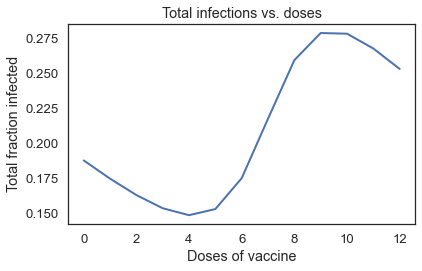

In [40]:
plot(infected_sweep)


decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

### Exercises

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

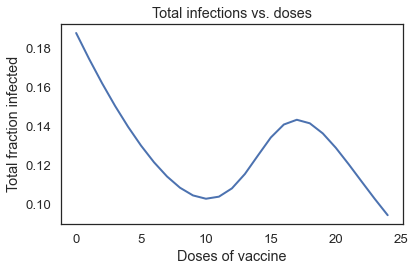

In [41]:
# Solution goes here
num_students = 90
budget = 1200
price_per_dose = 50
max_doses2 = int(budget / price_per_dose)
dose_array2 = linrange(max_doses2, endpoint=True)

infected_sweep2 = sweep_doses(dose_array2)
plot(infected_sweep2)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

Dropping the cost of vasccination lowers the entire curve and drops the overall infection rates. Additionally,  the frational infected as a function of doses is much steeper, indicating increasing utility as doses are given. The optimal point is now shifted to 10 doses which decreases infection rates to around 10% (compared to 15% for dose=100 and n=5) and still leaves $700 left for washing hand spending. After the local minimum the infection goes up but herd immunity seem to be hit at around 18 vaccines or 14.5 %. What's interesting is that if the entire allocation is given to vaccines (24 doses) we achieve a lower infection rate of 0.10. Thus it might make more sense to just allocate everything to vaccine as we get a lower rate. 

**Exercise:** Suppose we have the option to quarantine infected students.  For example, a student who feels ill might be moved to an infirmary, or a private dorm room, until they are no longer infectious.

How might you incorporate the effect of quarantine in the SIR model?

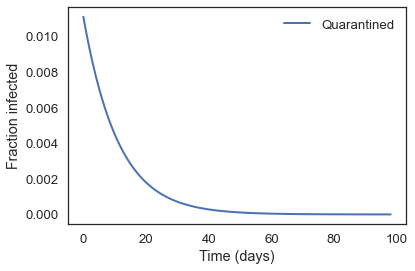

In [42]:
# Solution goes here
# One way would be to increase the time between contact since that would imply students are isolated.
# I'll increase to over the recovery time which implies that they are "isolated" until they recover. 

tc = 6      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
results = run_simulation(system, update_func)
plot(results.I, '-', label='Quarantined')
decorate(xlabel='Time (days)',
         ylabel='Fraction infected')

Another way we could roughly model Quarantine is to just reduce gamma since that would cut the infection rate down.
Alternatively we could also add a Quarantine segment into the model (Q) that queues a fraction of the students--and then releases them back to the system after a few days, and use that as an approxmation for gamma. 
In the end there are many ways we could go abou this problem--but the beauty of simulation/modeling is we can  build the scenarios and test them!